In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from scipy.stats import binom, rankdata
from multiprocessing import Pool
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt

clf = OneVsRestClassifier(RandomForestClassifier())

In [2]:
def subsetData(df,base):
    #define features and labels
    features = ['A','C','T','G','deletion']
    features.remove(base) 
    dfPredictors = df[features].values
    rowsum = np.sum(dfPredictors,axis=1)
    X = np.true_divide(dfPredictors.T  ,rowsum).T
    return np.array(X,dtype=np.float64)
pd.DataFrame.subsetData = subsetData

def getPvalue(correctReads,cov,seqErr):
    assert len(correctReads)==len(cov), 'Wrong length of vector!'
    ps = binom.cdf(correctReads,n=cov,p=1-seqErr)
    return ps

def filterData(df,hyp,seqErr,pThreshold):
    mismatchBases = df[['A','C','T','G']].values
    df['mismatch'] = np.sum(mismatchBases,axis=1)
    df['refRead'] = df['cov'] - df['mismatch']
    if hyp == 'hyp1':
        df['p'] = getPvalue(df['refRead'].values,df['cov'].values,seqErr)
    elif hyp == 'hyp2':
        df['secondRef'] = np.amax(mismatchBases,axis=1)
        df['correctHeteroReads'] = np.sum(df[['refRead','secondRef']],axis=1)
        df['p'] = getPvalue(df['correctHeteroReads'].values,df['cov'].values,seqErr)
    df['padj'] =  smm.multipletests(df['p'].values,alpha=0.05,method='fdr_bh')[1]
    df = df[(df['padj']<pThreshold) & (df['cov']>10)]
    return df
pd.DataFrame.filterData = filterData

def mergeAbbrev(abb):
    if abb in ['m1A','m1I']:
        return 'm1A|m1I'
    elif abb in ['m2G','m2,2G']:
        return 'm2G|m2,2G'
    else:
        return abb
    
def modificationType(abb):
    if abb in ['m1A|m1I','I','m3C','acp3U','m3U','m2G|m2,2G']:
        return 'On basepair'
    else:
        return 'not on basepair'

In [3]:
def get_roc(y_test, y_score, y_train):
    classes = np.unique(y_train)
    classes = np.append(classes,'null') #add null class to avoid true_binary model
    y = label_binarize(y_test, classes=classes)
    y = y[:,:-1]

    roc_auc = {}
    for i in range(len(classes[:-1])):
        multiclass = classes[i]
        fpr, tpr, _ = metrics.roc_curve(y[:, i], y_score[:, i])
        if len(tpr) > 2:
            roc_auc[multiclass] = metrics.auc(fpr, tpr)
    return roc_auc

def validation(X,Y):
    repeats = 10
    metric_list = [] 
    parameters = {'estimator__n_estimators':np.arange(5,40)}
        
    for i in np.arange(repeats):
        # split train test
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2,random_state=i)   
        loocv = cross_validation.LeaveOneOut(n = len(X_train))
        kfold = cross_validation.KFold(n = len(X_train),n_folds = 6)
        cv = GridSearchCV(clf,param_grid=parameters,n_jobs=-1, cv=kfold)
        cv.fit(X_train, y_train)
        tuned_model = cv.best_estimator_
        model = tuned_model.fit(X_train,y_train)
        y_score = model.predict_proba(X_test)
        roc_auc = get_roc(y_test, y_score, y_train)
        roc_df = pd.DataFrame(roc_auc, index=['auc'])
        roc_df = pd.melt(roc_df, value_name='AUC',var_name='classes')
        roc_df['repeat'] = np.repeat(i,len(roc_df))
        metric_list.append(roc_df)
    return pd.concat(metric_list,axis=0)
    
def trainBase(df, base):
    filtered_df = df[df['ref'] == base]
    classes = np.unique(filtered_df['abbrev'])
    if len(classes) != 1 and len(filtered_df)> 20:
        X = filtered_df.subsetData(base)
        Y = filtered_df['abbrev'].values
        res = validation(X,Y)
        res['base'] = np.repeat(base, len(res))
        return res

In [4]:
trainDf = pd.read_json('../trainSets/teiTable.json','table')\
        .filterData('hyp1', 0.05, 0.05)
trainDf['abbrev'] = map(mergeAbbrev,trainDf.abbrev)

In [5]:
auc = [trainBase(trainDf,base) for base in list('ACTG')]
auc = pd.concat(auc,axis=0)
auc['type'] = map(modificationType,auc['classes'])

/home/cdw2854/src/miniconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:530: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/cdw2854/src/miniconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:538: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


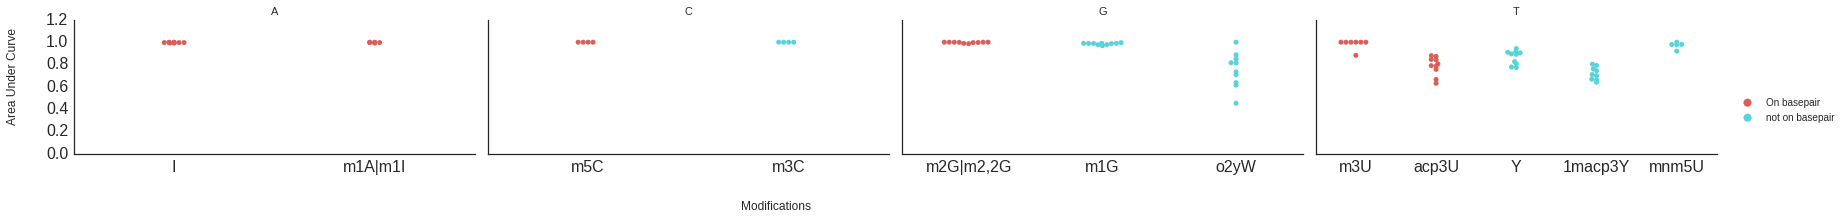

In [29]:
auc.sort_values(by='base',inplace=True)
sns.set_style('white')
with sns.plotting_context('paper',font_scale=2):
    p = sns.FacetGrid(data = auc, col = 'base', sharex=False, aspect = 2, size=3)
p.map(sns.swarmplot,'classes', 'AUC','type',palette=sns.color_palette("hls", 2))
p.add_legend()
p.set(ylim=(0,1.2))
p.set(xlabel=' ', ylabel=' ')
p.set_titles('{col_name}')
p.fig.text(x = 0, y = 0.8, s='Area Under Curve', rotation = 90, size=12) # y axis label
p.fig.text(x = 0.4, y = 0, s= 'Modifications') # x axis label